# 🌦️ Multi-Output Weather Forecasting: Traditional ML & Time Series Models

This notebook provides a clean, modular workflow for multi-output weather forecasting (predicting temperature, wind speed, humidity, pressure, and precipitation) using only traditional machine learning and time series models. Deep learning models are excluded as per requirements.

**Workflow:**
1. Data Loading & Cleaning
2. Feature Engineering
3. Data Preparation for Multi-Output
4. Model Training (RandomForest, GradientBoosting, etc. with MultiOutputRegressor)
5. Time Series Models (ARIMA, Exponential Smoothing, etc.)
6. Evaluation & Visualization
7. Model Saving


In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pickle
import os
from datetime import timedelta

print("📦 All libraries imported successfully!")


📦 All libraries imported successfully!


## 1. Data Loading & Initial Exploration

Load the weather dataset and perform initial exploration to understand its structure, missing values, and key features.

In [2]:
# Load Weather Data
print("🔄 Loading weather data...")

# Load the dataset (update path as needed)
df = pd.read_csv("../Dataset/Weather_data_combined.csv")

# Display basic info
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
display(df.head())

# Check for missing values
missing = df.isnull().sum()
print("\nMissing values:")
print(missing[missing > 0])

# Data types
print("\nData types:")
print(df.dtypes)


🔄 Loading weather data...
Shape: (24070, 35)
Columns: ['last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'country', 'location_name', 'region', 'latitude', 'longitude', 'timezone', 'last_updated']


,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,...,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,country,location_name,region,latitude,longitude,timezone,last_updated
0,1693000001,27.5,81.5,12.8,20.5,281,WNW,1008,29.77,0.0,...,18.5,1,2,India,Ashoknagar,Madhya Pradesh,24.57,77.72,Asia/Kolkata,8/29/23 10:45
1,1693000002,27.5,81.5,9.6,15.5,287,WNW,1008,29.78,0.0,...,14.2,1,1,India,Raisen,Madhya Pradesh,23.33,77.80,Asia/Kolkata,8/29/23 10:45
2,1693000003,26.3,79.3,11.4,18.4,317,NW,1009,29.78,0.0,...,20.7,2,2,India,Chhindwara,Madhya Pradesh,22.07,78.93,Asia/Kolkata,8/29/23 10:45
3,1693000004,25.6,78.1,10.5,16.9,297,WNW,1009,29.80,0.0,...,6.6,1,1,India,Betul,Madhya Pradesh,21.86,77.93,Asia/Kolkata,8/29/23 10:45
4,1693000005,27.2,81.0,10.1,16.2,274,W,1009,29.79,0.0,...,14.8,1,1,India,Hoshangabad,Madhya Pradesh,22.75,77.72,Asia/Kolkata,8/29/23 10:45



Missing values:
Series([], dtype: int64)

Data types:
last_updated_epoch                int64
temperature_celsius             float64
temperature_fahrenheit          float64
wind_mph                        float64
wind_kph                        float64
wind_degree                       int64
wind_direction                   object
pressure_mb                       int64
pressure_in                     float64
precip_mm                       float64
precip_in                       float64
humidity                          int64
cloud                             int64
feels_like_celsius              float64
feels_like_fahrenheit           float64
visibility_km                   float64
visibility_miles                  int64
uv_index                          int64
gust_mph                        float64
gust_kph                        float64
air_quality_Carbon_Monoxide     float64
air_quality_Ozone               float64
air_quality_Nitrogen_dioxide    float64
air_quality_Sulphur_dioxi

In [3]:
# Data Cleaning & Preprocessing
print("🧹 Cleaning and preprocessing data...")

df_clean = df.copy()

# Parse date column (try to find a suitable one)
date_cols = [col for col in df_clean.columns if 'date' in col.lower() or 'time' in col.lower()]
if date_cols:
    date_col = date_cols[0]
    df_clean[date_col] = pd.to_datetime(df_clean[date_col])
    df_clean.set_index(date_col, inplace=True)
    df_clean.sort_index(inplace=True)
else:
    print("No date column found. Creating synthetic date index.")
    df_clean['date'] = pd.date_range(start='2020-01-01', periods=len(df_clean), freq='H')
    df_clean.set_index('date', inplace=True)

# Remove non-numeric columns not useful for modeling
text_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
for col in text_cols:
    if col not in ['city', 'district', 'state']:
        df_clean.drop(columns=col, inplace=True)

# Fill missing values (forward fill, then backward fill)
df_clean.fillna(method='ffill', inplace=True)
df_clean.fillna(method='bfill', inplace=True)

# Drop any remaining missing
print(f"Rows before dropna: {len(df_clean)}")
df_clean.dropna(inplace=True)
print(f"Rows after dropna: {len(df_clean)}")

display(df_clean.head())


🧹 Cleaning and preprocessing data...
Rows before dropna: 24070
Rows after dropna: 24070


/var/folders/53/g4qg79gd5bv785t07c5l01x40000gn/T/ipykernel_46821/2795276559.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean.fillna(method='ffill', inplace=True)
/var/folders/53/g4qg79gd5bv785t07c5l01x40000gn/T/ipykernel_46821/2795276559.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean.fillna(method='bfill', inplace=True)


,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,precip_mm,precip_in,humidity,...,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,latitude,longitude
last_updated_epoch,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:01.693000001,27.5,81.5,12.8,20.5,281,1008,29.77,0.0,0.0,67,...,243.7,45.8,1.7,3.1,12.6,18.5,1,2,24.57,77.72
1970-01-01 00:00:01.693000002,27.5,81.5,9.6,15.5,287,1008,29.78,0.0,0.0,70,...,240.3,38.3,2.1,2.6,10.7,14.2,1,1,23.33,77.80
1970-01-01 00:00:01.693000003,26.3,79.3,11.4,18.4,317,1009,29.78,0.0,0.0,70,...,220.3,57.2,0.6,1.7,16.8,20.7,2,2,22.07,78.93
1970-01-01 00:00:01.693000004,25.6,78.1,10.5,16.9,297,1009,29.80,0.0,0.0,76,...,200.3,25.0,1.2,1.1,4.9,6.6,1,1,21.86,77.93
1970-01-01 00:00:01.693000005,27.2,81.0,10.1,16.2,274,1009,29.79,0.0,0.0,74,...,257.0,30.8,2.2,1.8,11.4,14.8,1,1,22.75,77.72


## 2. Exploratory Data Analysis (EDA)

Visualize and analyze the main weather variables and their relationships.

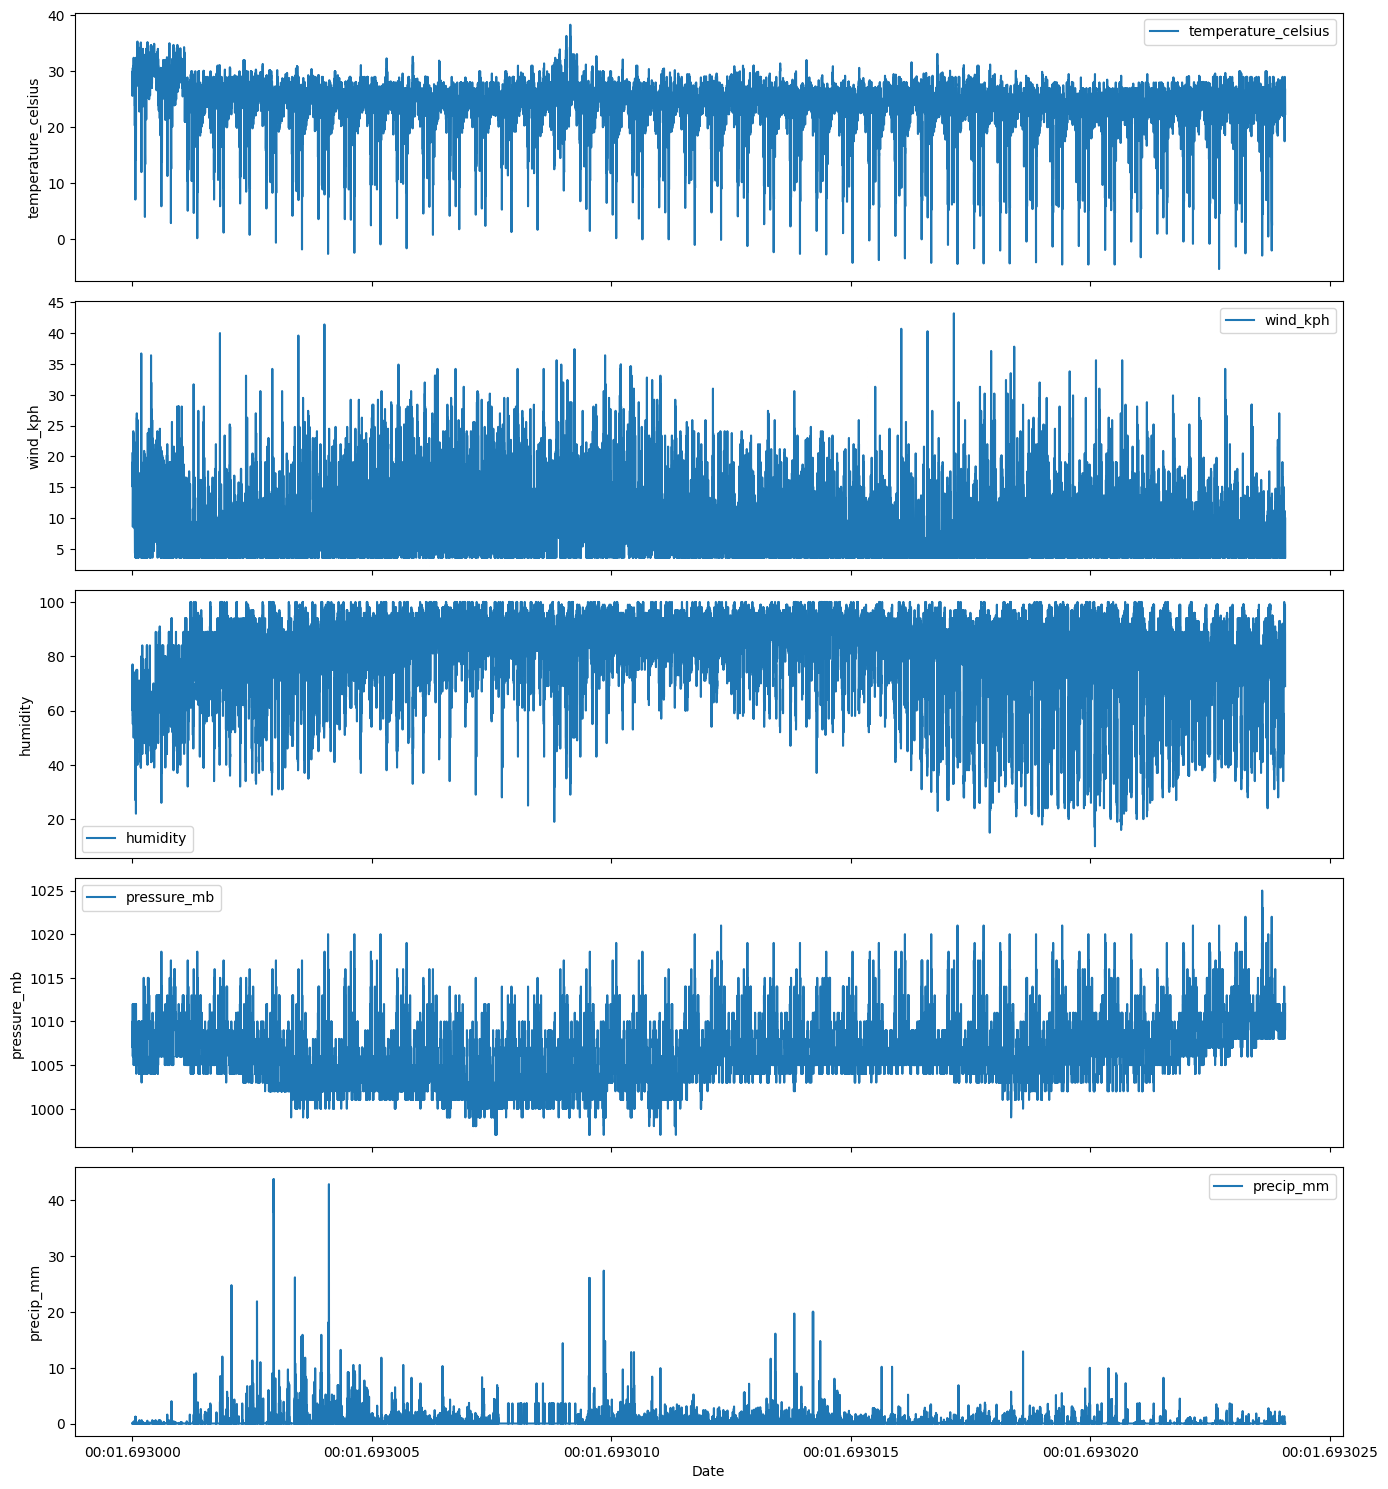

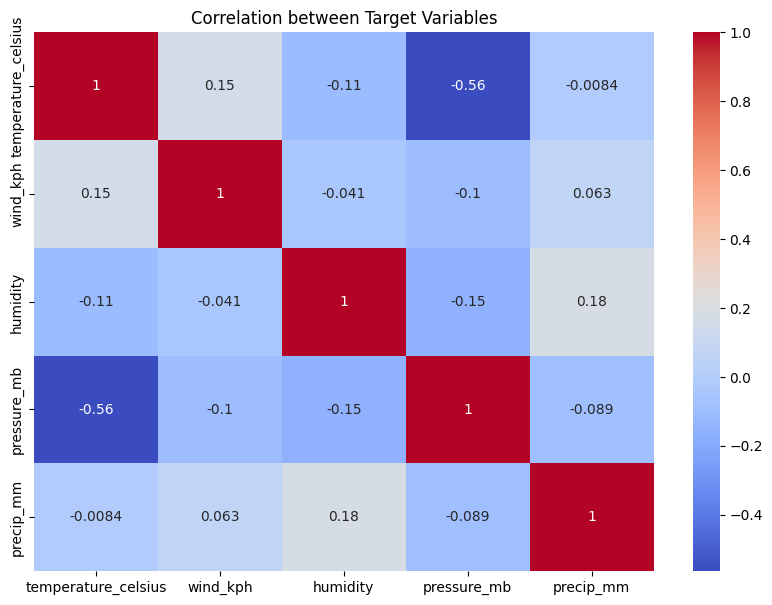

In [4]:
# EDA: Time Series Plots & Correlation
import matplotlib.dates as mdates

# Select target variables for multi-output forecasting
targets = ['temperature_celsius', 'wind_kph', 'humidity', 'pressure_mb', 'precip_mm']

# Plot time series for each target
fig, axes = plt.subplots(len(targets), 1, figsize=(14, 3*len(targets)), sharex=True)
for i, col in enumerate(targets):
    if col in df_clean.columns:
        axes[i].plot(df_clean.index, df_clean[col], label=col)
        axes[i].set_ylabel(col)
        axes[i].legend()
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df_clean[targets].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Target Variables')
plt.show()


## ⚙️ 3. Feature Engineering for Time Series

Creating time-based features and lag variables to capture temporal patterns and improve model performance.

In [5]:
# Feature Engineering: Time-based, Lag, and Rolling Features
print("⚙️ Feature engineering...")
df_feat = df_clean.copy()

# Time-based features
df_feat['year'] = df_feat.index.year
df_feat['month'] = df_feat.index.month
df_feat['day'] = df_feat.index.day
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['dayofyear'] = df_feat.index.dayofyear

def add_lag_features(df, cols, lags=[1,2,3,7]):
    for col in cols:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
add_lag_features(df_feat, targets)

def add_rolling_features(df, cols, windows=[3,7]):
    for col in cols:
        for w in windows:
            df[f'{col}_rollmean{w}'] = df[col].rolling(window=w).mean()
            df[f'{col}_rollstd{w}'] = df[col].rolling(window=w).std()
add_rolling_features(df_feat, targets)

# Drop rows with NaN from lag/rolling
df_feat.dropna(inplace=True)

# --- Data Leakage Prevention: Remove features highly correlated with any target at the same timestamp ---
print("Checking for highly correlated features with targets (|r| > 0.95)...")
correlation_threshold = 0.95
corr_matrix = df_feat.corr().abs()
features_to_drop = set()
for target in targets:
    for col in df_feat.columns:
        if col not in targets and corr_matrix.loc[target, col] > correlation_threshold:
            features_to_drop.add(col)
if features_to_drop:
    print(f"Dropping {len(features_to_drop)} features due to high correlation with targets:")
    for f in features_to_drop:
        print(f"  - {f}")
    df_feat.drop(columns=list(features_to_drop), inplace=True)
else:
    print("No highly correlated features found.")

print(f"Feature set shape: {df_feat.shape}")
display(df_feat.head())


⚙️ Feature engineering...
Checking for highly correlated features with targets (|r| > 0.95)...
Dropping 6 features due to high correlation with targets:
  - precip_in
  - pressure_in
  - feels_like_fahrenheit
  - wind_mph
  - temperature_fahrenheit
  - feels_like_celsius
Feature set shape: (24063, 67)


,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,visibility_km,visibility_miles,uv_index,...,humidity_rollmean7,humidity_rollstd7,pressure_mb_rollmean3,pressure_mb_rollstd3,pressure_mb_rollmean7,pressure_mb_rollstd7,precip_mm_rollmean3,precip_mm_rollstd3,precip_mm_rollmean7,precip_mm_rollstd7
last_updated_epoch,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:01.693000008,27.7,17.6,277,1008,0.0,71,21,10.0,6,7,...,72.571429,3.047247,1009.000000,1.000000,1008.857143,0.690066,0.033333,0.057735,0.014286,0.037796
1970-01-01 00:00:01.693000009,30.0,18.7,288,1007,0.0,60,22,10.0,6,8,...,71.142857,5.669467,1008.333333,1.527525,1008.714286,0.951190,0.033333,0.057735,0.014286,0.037796
1970-01-01 00:00:01.693000010,26.0,19.1,300,1012,0.0,74,50,5.0,3,6,...,71.714286,5.736267,1009.000000,2.645751,1009.142857,1.573592,0.000000,0.000000,0.014286,0.037796
1970-01-01 00:00:01.693000011,30.6,15.8,284,1006,0.0,57,58,10.0,6,8,...,69.000000,7.571878,1008.333333,3.214550,1008.714286,1.976047,0.000000,0.000000,0.014286,0.037796
1970-01-01 00:00:01.693000012,30.3,8.6,316,1008,0.1,55,70,10.0,6,7,...,66.285714,8.788521,1008.666667,3.055050,1008.571429,1.988060,0.033333,0.057735,0.028571,0.048795


## 4. Data Preparation and Splitting

Prepare feature matrix and target matrix for multi-output regression. Split into train and test sets.

In [6]:
# Prepare Features and Targets, Train/Test Split
print("Preparing data for multi-output regression...")

# Define features and targets
feature_cols = [col for col in df_feat.columns if col not in targets]
X = df_feat[feature_cols]
Y = df_feat[targets]

# Train/test split (chronological, 80/20)
split_idx = int(0.8 * len(df_feat))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
Y_train, Y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]

# Feature scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")


Preparing data for multi-output regression...
X_train: (19250, 62), Y_train: (19250, 5)
X_test: (4813, 62), Y_test: (4813, 5)


In [7]:
print(X_train.columns)

Index(['wind_degree', 'cloud', 'visibility_km', 'visibility_miles', 'uv_index',
       'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'latitude',
       'longitude', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
       'temperature_celsius_lag1', 'temperature_celsius_lag2',
       'temperature_celsius_lag3', 'temperature_celsius_lag7', 'wind_kph_lag1',
       'wind_kph_lag2', 'wind_kph_lag3', 'wind_kph_lag7', 'humidity_lag1',
       'humidity_lag2', 'humidity_lag3', 'humidity_lag7', 'pressure_mb_lag1',
       'pressure_mb_lag2', 'pressure_mb_lag3', 'pressure_mb_lag7',
       'precip_mm_lag1', 'precip_mm_lag2', 'precip_mm_lag3', 'precip_mm_lag7',
       'temperature_celsius_rollmean3', 'temperature_celsius_rollstd3',
       'temperature_celsius_rollmean7', 'temperature_celsi

## 5. Multi-Output Machine Learning Models

Train and evaluate traditional ML models (RandomForest, GradientBoosting, AdaBoost) for multi-output regression.

In [8]:
# Train Multi-Output ML Models
print("Training multi-output ML models...")
from collections import defaultdict

ml_models = {
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=50, random_state=42)
}

results = defaultdict(dict)
predictions = {}

for name, model in ml_models.items():
    print(f"Training {name}...")
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train_scaled, Y_train)
    Y_pred = multi_model.predict(X_test_scaled)
    predictions[name] = Y_pred
    # Metrics for each target
    for i, target in enumerate(targets):
        mse = mean_squared_error(Y_test.iloc[:, i], Y_pred[:, i])
        mae = mean_absolute_error(Y_test.iloc[:, i], Y_pred[:, i])
        r2 = r2_score(Y_test.iloc[:, i], Y_pred[:, i])
        results[name][target] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} done.")

print("All ML models trained.")


Training multi-output ML models...
Training GradientBoosting...
GradientBoosting done.
Training AdaBoost...
GradientBoosting done.
Training AdaBoost...
AdaBoost done.
All ML models trained.
AdaBoost done.
All ML models trained.


## 6. Time Series Models (Univariate)

Fit and evaluate time series models (SARIMAX, Exponential Smoothing) for each target variable individually.

In [9]:
# Time Series Models: SARIMAX & Exponential Smoothing
print("Fitting time series models for each target...")
time_series_results = defaultdict(dict)
time_series_preds = {}

for target in targets:
    print(f"\nTarget: {target}")
    y_train = Y_train[target]
    y_test = Y_test[target]
    # SARIMAX (simple seasonal order, can be tuned)
    try:
        sarimax = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,0,1,12))
        sarimax_fit = sarimax.fit(disp=False)
        sarimax_pred = sarimax_fit.forecast(steps=len(y_test))
        time_series_preds[f'SARIMAX_{target}'] = sarimax_pred
        mse = mean_squared_error(y_test, sarimax_pred)
        mae = mean_absolute_error(y_test, sarimax_pred)
        r2 = r2_score(y_test, sarimax_pred)
        time_series_results['SARIMAX'][target] = {'MSE': mse, 'MAE': mae, 'R2': r2}
        print(f"SARIMAX done.")
    except Exception as e:
        print(f"SARIMAX failed: {e}")
    # Exponential Smoothing
    try:
        exp = ExponentialSmoothing(y_train, trend='add', seasonal=None)
        exp_fit = exp.fit()
        exp_pred = exp_fit.forecast(steps=len(y_test))
        time_series_preds[f'ExpSmooth_{target}'] = exp_pred
        mse = mean_squared_error(y_test, exp_pred)
        mae = mean_absolute_error(y_test, exp_pred)
        r2 = r2_score(y_test, exp_pred)
        time_series_results['ExpSmooth'][target] = {'MSE': mse, 'MAE': mae, 'R2': r2}
        print(f"ExpSmooth done.")
    except Exception as e:
        print(f"ExpSmooth failed: {e}")
print("All time series models complete.")


Fitting time series models for each target...

Target: temperature_celsius


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


SARIMAX done.


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


ExpSmooth done.

Target: wind_kph


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


SARIMAX done.


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


ExpSmooth done.

Target: humidity


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


SARIMAX done.


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


ExpSmooth done.

Target: pressure_mb


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


SARIMAX done.


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


ExpSmooth done.

Target: precip_mm


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


SARIMAX done.


/Users/digantamandal/Desktop/Capital_One_Launchpad/myenv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


ExpSmooth done.
All time series models complete.


## 7. Evaluation and Visualization

Compare model performance for each target variable and visualize predictions vs actuals.


GradientBoosting Results:


,MSE,MAE,R2
temperature_celsius,1.785172,0.914745,0.880314
wind_kph,1.403376,0.769968,0.921479
humidity,23.512055,3.492720,0.935583
pressure_mb,1.468158,0.904127,0.811115
precip_mm,0.016076,0.039865,0.946100



AdaBoost Results:


,MSE,MAE,R2
temperature_celsius,3.272464,1.335496,0.780599
wind_kph,5.637804,1.949317,0.684558
humidity,66.692299,6.713274,0.817279
pressure_mb,2.178378,1.120801,0.719742
precip_mm,0.364032,0.535449,-0.220551



SARIMAX Results:


,MSE,MAE,R2
temperature_celsius,23.123296,3.236089,-0.550288
wind_kph,33.424888,5.037050,-0.870162
humidity,407.806683,15.531065,-0.117294
pressure_mb,15.494875,3.156080,-0.993486
precip_mm,0.312535,0.121349,-0.047888



ExpSmooth Results:


,MSE,MAE,R2
temperature_celsius,20.783077,2.975071,-0.393390
wind_kph,28.755776,4.613861,-0.608920
humidity,443.357457,16.130187,-0.214695
pressure_mb,15.673173,3.166774,-1.016425
precip_mm,0.313084,0.122234,-0.049728


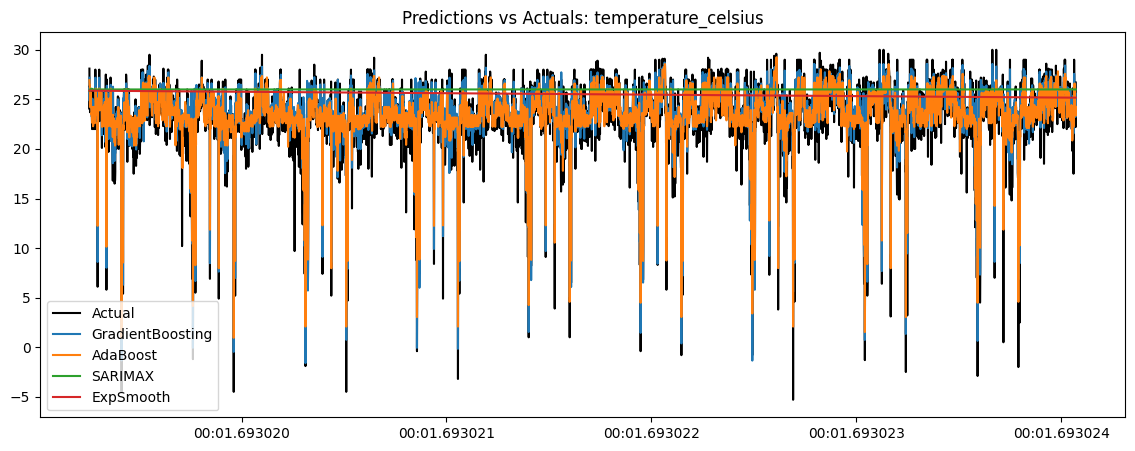

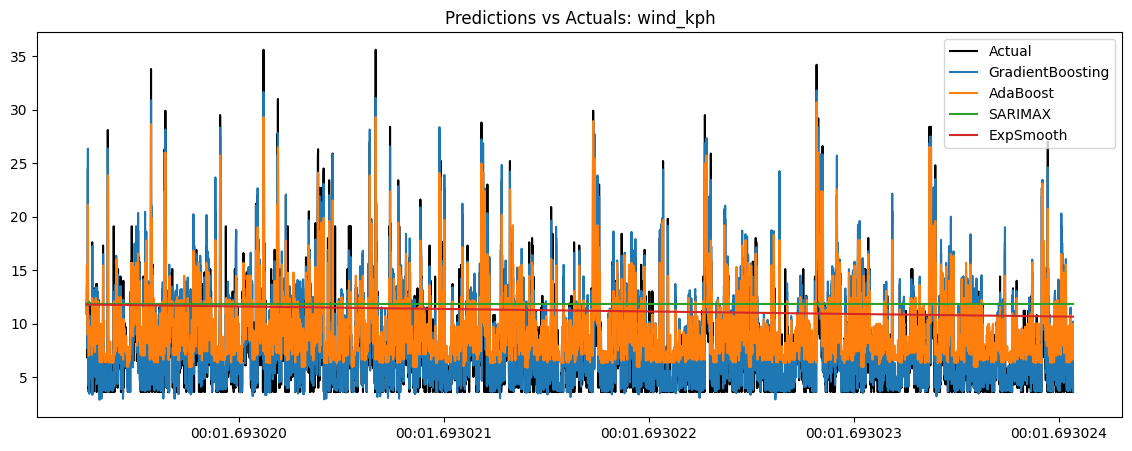

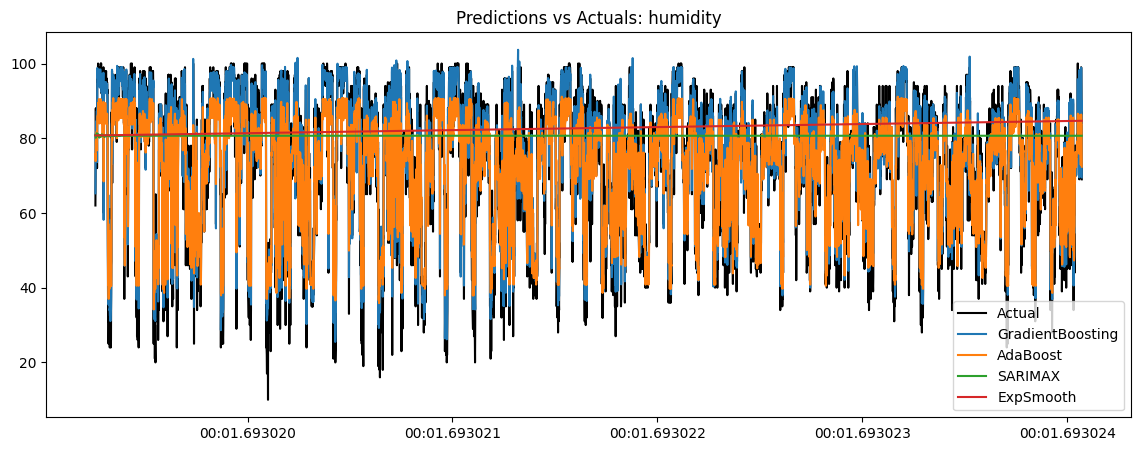

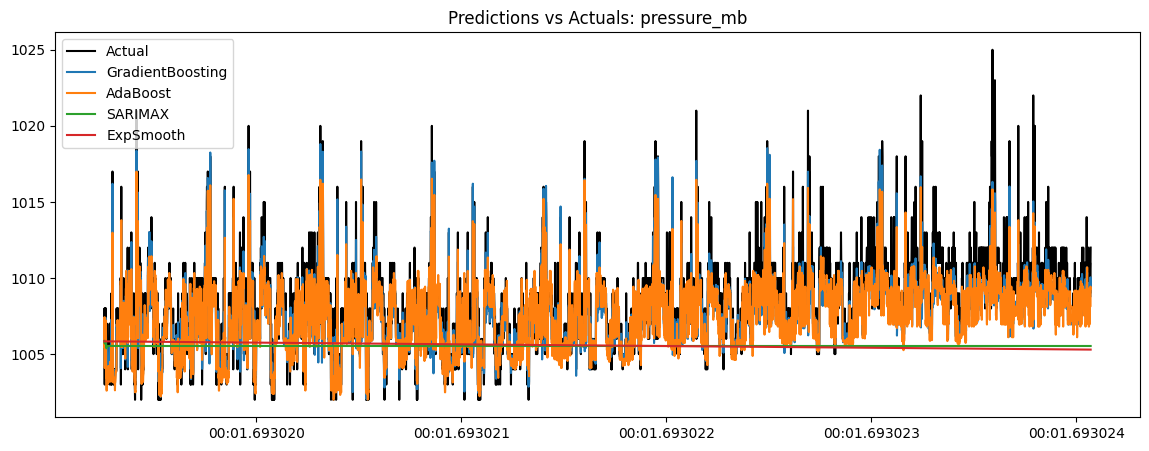

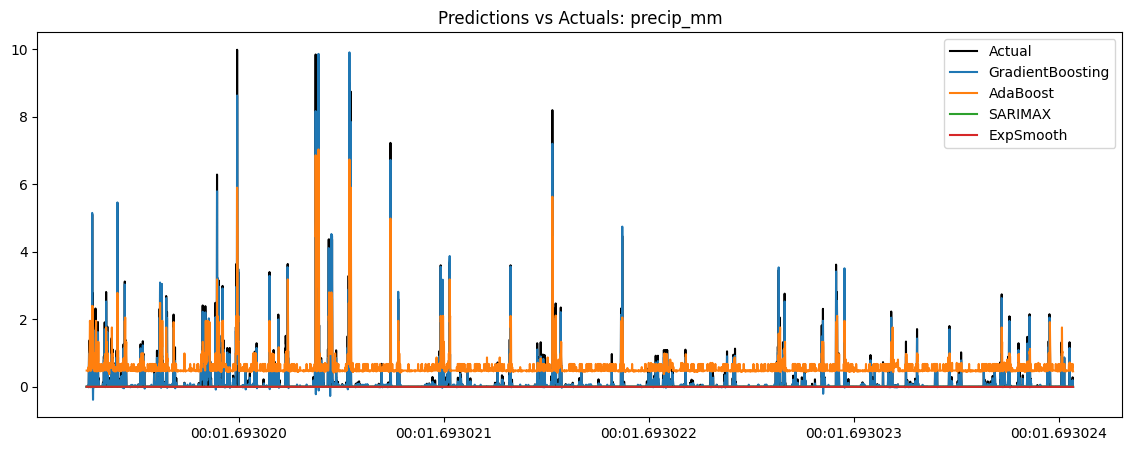

In [10]:
# Evaluation: Metrics Table & Plots
import pandas as pd

# ML model results
for name in ml_models.keys():
    print(f"\n{name} Results:")
    display(pd.DataFrame(results[name]).T)

# Time series model results
for ts_name in time_series_results.keys():
    print(f"\n{ts_name} Results:")
    display(pd.DataFrame(time_series_results[ts_name]).T)

# Plot predictions vs actuals for each target
for target in targets:
    plt.figure(figsize=(14,5))
    plt.plot(Y_test.index, Y_test[target], label='Actual', color='black')
    for name in ml_models.keys():
        plt.plot(Y_test.index, predictions[name][:, targets.index(target)], label=f'{name}')
    if f'SARIMAX_{target}' in time_series_preds:
        plt.plot(Y_test.index, time_series_preds[f'SARIMAX_{target}'], label='SARIMAX')
    if f'ExpSmooth_{target}' in time_series_preds:
        plt.plot(Y_test.index, time_series_preds[f'ExpSmooth_{target}'], label='ExpSmooth')
    plt.title(f'Predictions vs Actuals: {target}')
    plt.legend()
    plt.show()


## 8. Model Saving

Save the best performing ML models for each target variable for future inference.

In [11]:
# Save Best ML Models
save_dir = "../models/Weather_Forecasting"
os.makedirs(save_dir, exist_ok=True)

for name, model in ml_models.items():
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train_scaled, Y_train)
    model_path = os.path.join(save_dir, f"{name}_multioutput.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(multi_model, f)
    print(f"Saved {name} model to {model_path}")


Saved GradientBoosting model to ../models/Weather_Forecasting/GradientBoosting_multioutput.pkl
Saved AdaBoost model to ../models/Weather_Forecasting/AdaBoost_multioutput.pkl
Saved AdaBoost model to ../models/Weather_Forecasting/AdaBoost_multioutput.pkl


## 9. Model Interpretation with SHAP

Using SHAP (SHapley Additive exPlanations) to understand the model's predictions. This helps to see which features are most influential for each of the target variables.

Generating SHAP plots using the faster TreeExplainer...

SHAP Summary Plot for: temperature_celsius


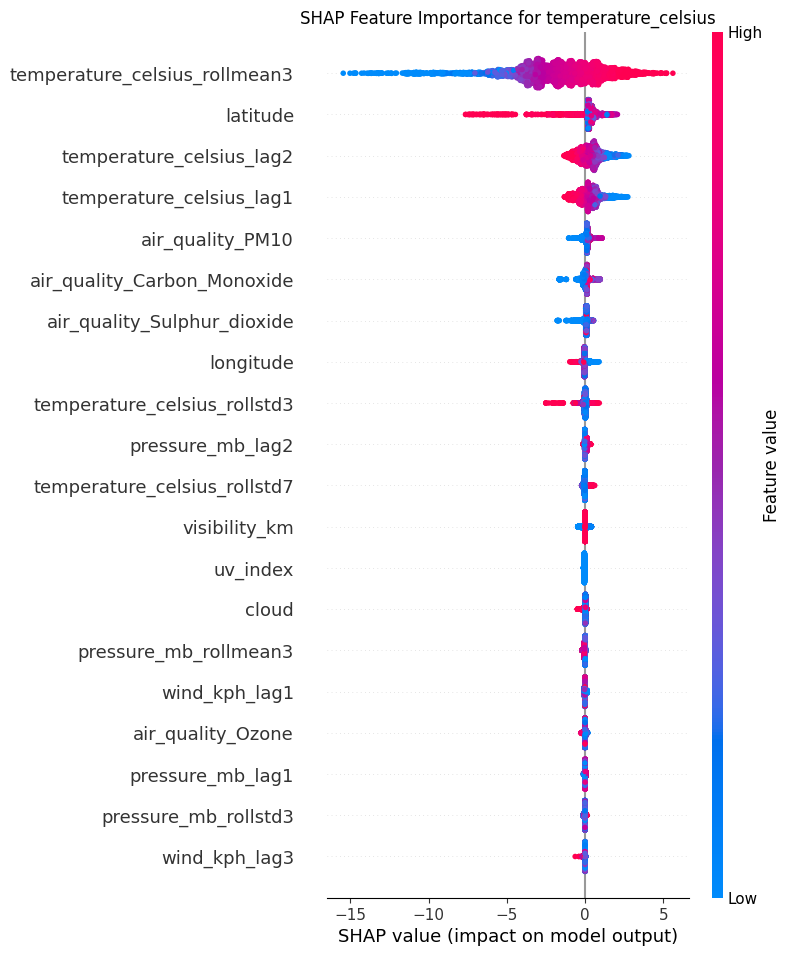


SHAP Summary Plot for: wind_kph


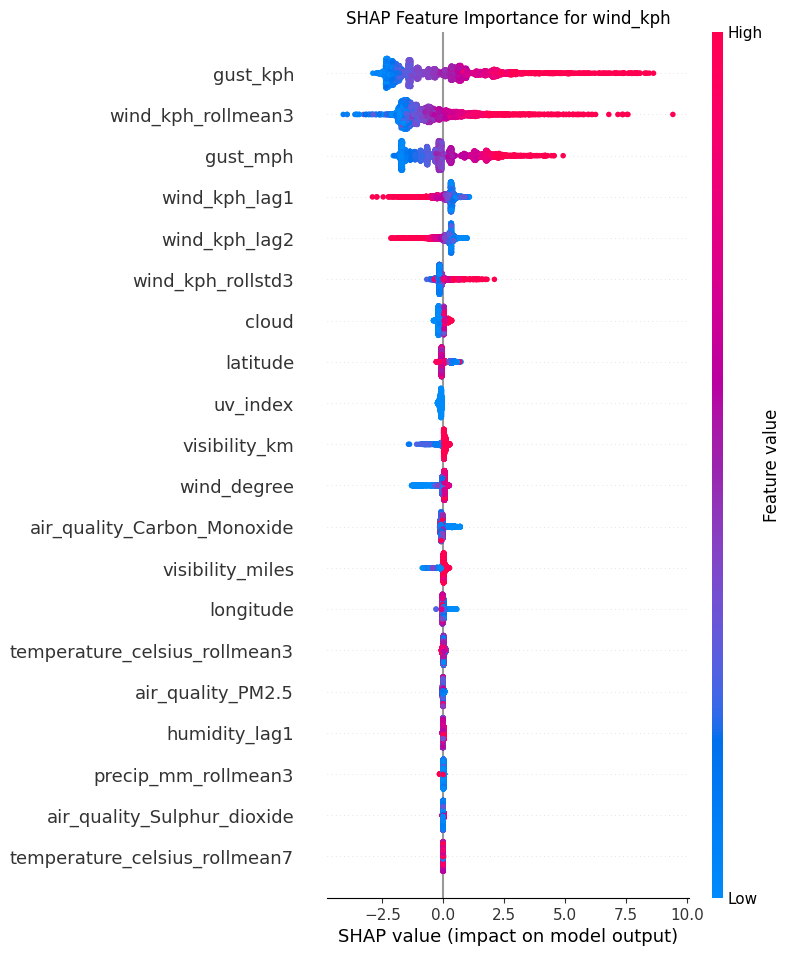


SHAP Summary Plot for: humidity


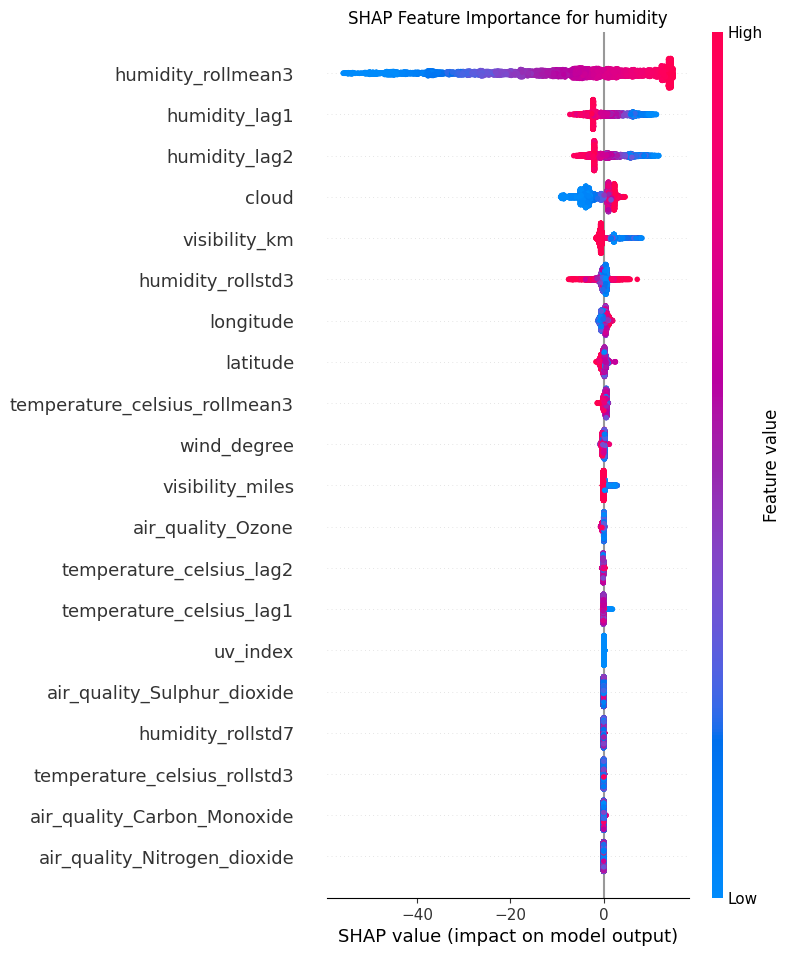


SHAP Summary Plot for: pressure_mb


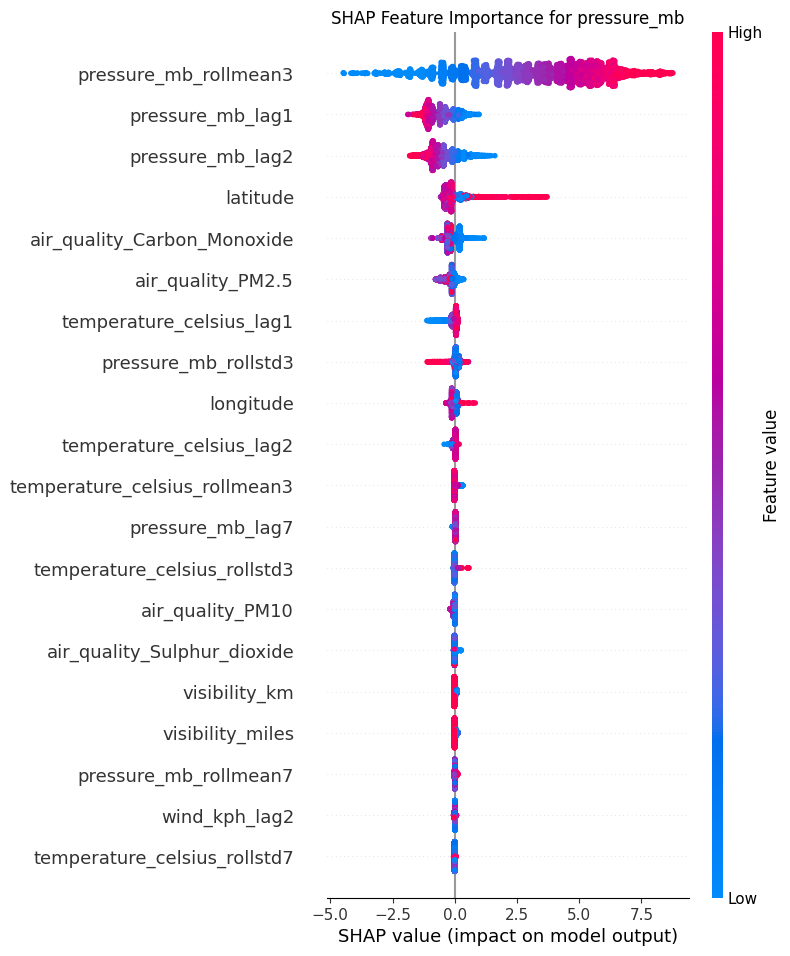


SHAP Summary Plot for: precip_mm


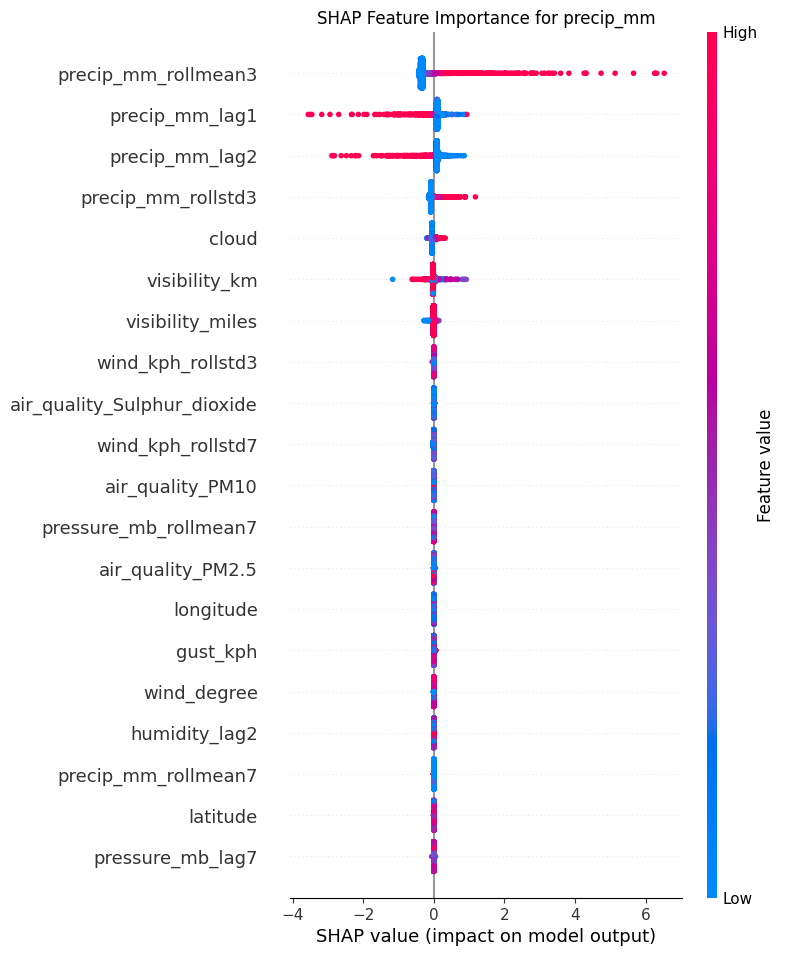


All SHAP plots generated.


In [16]:
import shap

# Since GradientBoosting is a tree-based model, we can use the much faster TreeExplainer.
# We need to apply it to each of the base estimators inside the MultiOutputRegressor.

# 1. Ensure the multi-output model is trained
model_to_explain = ml_models['GradientBoosting']
multi_model_to_explain = MultiOutputRegressor(model_to_explain)
multi_model_to_explain.fit(X_train_scaled, Y_train)

# 2. Iterate through each target's model, explain, and plot
print("Generating SHAP plots using the faster TreeExplainer...")
for i, target in enumerate(targets):
    print(f"\nSHAP Summary Plot for: {target}")
    
    # Get the individual estimator for the target
    estimator = multi_model_to_explain.estimators_[i]
    
    # Create a TreeExplainer for the specific estimator
    explainer = shap.TreeExplainer(estimator)
    
    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Plot the summary
    # We use X_test (unscaled) for better feature value visualization on the plot
    shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, show=False)
    plt.title(f"SHAP Feature Importance for {target}")
    plt.show()

print("\nAll SHAP plots generated.")